In [1]:
import sys
sys.path.append("../../")

from astronn import datasets
from astronn import models

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Create a dataset with 1Mll theoretical stars oscilations

In [2]:
star_models = datasets.starmodels()
df = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150)

#### Print sample vectors from Dataset

In [3]:
for row in df.take(1):
    print(row)

(<tf.Tensor: id=1732, shape=(150, 406, 3), dtype=float32, numpy=
array([[[ 0.000e+00,  0.000e+00,  1.000e+00],
        [ 0.000e+00,  0.000e+00,  9.903e-01],
        [ 0.000e+00,  1.000e+00,  9.167e-01],
        ...,
        [ 0.000e+00,  0.000e+00,  2.800e-02],
        [ 0.000e+00,  0.000e+00,  4.480e-02],
        [ 0.000e+00,  0.000e+00,  2.203e-01]],

       [[ 0.000e+00,  0.000e+00,  1.000e+00],
        [ 0.000e+00,  1.000e+00,  9.897e-01],
        [ 0.000e+00,  0.000e+00,  9.112e-01],
        ...,
        [ 0.000e+00,  0.000e+00, -2.200e-02],
        [ 0.000e+00,  0.000e+00,  2.000e-04],
        [ 0.000e+00,  0.000e+00,  9.070e-02]],

       [[ 0.000e+00,  0.000e+00,  9.999e-01],
        [ 0.000e+00,  0.000e+00,  9.911e-01],
        [ 0.000e+00,  0.000e+00,  9.232e-01],
        ...,
        [ 0.000e+00,  0.000e+00,  3.780e-02],
        [ 0.000e+00,  0.000e+00,  4.640e-02],
        [ 0.000e+00,  0.000e+00,  1.052e-01]],

       ...,

       [[ 0.000e+00,  0.000e+00,  1.000e+00],
   

In [4]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

#### Take one example

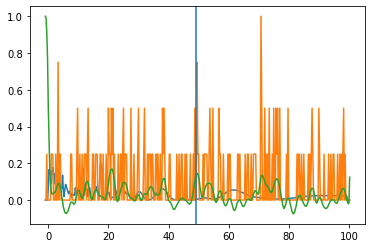

In [5]:
line = [line for line in df.take(1)]

x = np.arange(-1, 100.5, 0.25)
plt.plot(x, line[0][0][0,:,0])
plt.plot(x, normalize(line[0][0][0,:,1]))
plt.plot(x, line[0][0][0,:,2])

target = np.where(line[0][1][0].numpy().flat == 1)[0].flat[0]
plt.axvline(x=target)

#### Sampling to check non all-zeros one-hot vector target

In [6]:
aux = []
for row in df.take(50):
    for r in row[1]:
        if len(np.where(r[0])[0]) > 0:
            aux.append(np.where(r[0])[0][0])
        else:
            print(row)
            print(r[0])
            0 / 0

(array([ 635., 1000.,  833., 1040., 1271., 1241.,  972.,  272.,  161.,
          75.]),
 array([19., 27., 35., 43., 51., 59., 67., 75., 83., 91., 99.]),
 <a list of 10 Patch objects>)

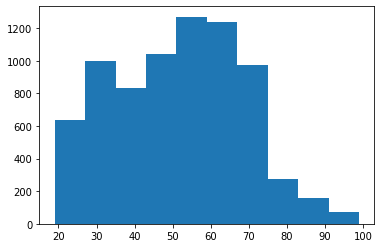

In [7]:
plt.hist(aux) # PLot histogram of targets

#### Create a Separable convolution model

In [8]:
sepconv_mod = models.separableconvnn() #init model
sepconv_mod.compile(learning_rate=0.001) # compile model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 402, 50)           1700      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 134, 50)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 134, 50)           200       
_________________________________________________________________
dropout (Dropout)            (None, 134, 50)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 130, 50)           27550     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 50)            0         
____________________________

#### Train model with dataset

In [9]:
history = sepconv_mod.model.fit(df, steps_per_epoch=100, epochs=50)

Train for 100 steps
Epoch 1/50
100/100 [==============================] - 16s 158ms/step - loss: 2.9379 - accuracy: 0.0174
Epoch 2/50
100/100 [==============================] - 14s 143ms/step - loss: 2.3353 - accuracy: 0.0182
Epoch 3/50
100/100 [==============================] - 14s 143ms/step - loss: 2.0560 - accuracy: 0.0192
Epoch 4/50
100/100 [==============================] - 14s 143ms/step - loss: 1.8683 - accuracy: 0.0190
Epoch 5/50
100/100 [==============================] - 14s 144ms/step - loss: 1.8218 - accuracy: 0.0186
Epoch 6/50
100/100 [==============================] - 14s 144ms/step - loss: 1.9359 - accuracy: 0.0181
Epoch 7/50
100/100 [==============================] - 14s 143ms/step - loss: 1.8404 - accuracy: 0.0180
Epoch 8/50
100/100 [==============================] - 14s 144ms/step - loss: 1.7864 - accuracy: 0.0194
Epoch 9/50
100/100 [==============================] - 14s 144ms/step - loss: 1.7638 - accuracy: 0.0196
Epoch 10/50
100/100 [==============================] 

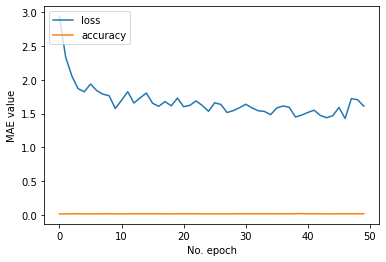

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#### Save models and weigths on disk

In [14]:
sepconv_mod.save("/tmp/sepconvnn_dos")

INFO:tensorflow:Assets written to: /tmp/sepconvnn_dos/assets


#### Inference on one sample star

In [12]:
for row in df.take(1):
    print("Batch shape (%s %s)" % (row[0].shape, row[1].shape))
    # Select first row on the batch
    X_star_test = row[0][0].numpy()
    y_star_test = row[1][0].numpy()
    
y_hats = sepconv_mod.predict_classes(X_star_test.reshape(1, 406, 3))
print("\nInference: Y_hat=%s | Y_test=%s" % (y_hats, np.where(y_star_test[0]==1)[0]))

Batch shape ((150, 406, 3) (150, 1, 100))

Inference: Y_hat=[33] | Y_test=[31]
